# Introduction
In an increasingly online world, it is getting more and more important to make these virtual spaces safer. People from all age-groups, ethnicities, and races have access to the internet. While social media was designed to connect people, it also has several issues. Hate-speech and toxicity is very prevalent in the online community. Hence, it is very important to control such content so that it does not reach the ears of the naive audience.

This application aims to classify any audio as toxic/ abusive/ racist/ hate-speech/ or a normal audio. Furthermore, censoring of any abusive language is also a function that has been included.

In [1]:
#Imports

# import kagglehub #audio-based-violence-detection-dataset I was initially using this dataset for training my own model

import librosa
import librosa.display
import librosa.core
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import fftpack
from os import listdir
import os
import IPython.display as ipd

import whisper
from pydub import AudioSegment
import abuse as ab #TAPAD

from jiwer import wer
import noisereduce as nr
import soundfile as sf
from transformers import pipeline, AutoTokenizer

from pydub.generators import Sine
import string

As the application aims to classify the audio as abusive or normal, it is necessary to first obtain a model.
The earlier implementation of this application was on a custom build Random-Forest, but the accuracy was poor. Hence, HuggingFace's **Toxic-Bert** is being used instead.
Bert has a limit to the size of chunks it can take for processing, so it needs to be divided in chunks and processed.

In [2]:


# Load toxicity classifier and tokenizer
# using Huggingface's toxic bert
toxicity_classifier = pipeline("text-classification", model="unitary/toxic-bert", top_k=None)
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")

def chunk_text_safe(text, tokenizer, max_length=512):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = []
    # doing in chunks as bert can only predict for a smaller data
    for i in range(0, len(tokens), max_length):
        chunk = tokens[i:i+max_length]
        decoded = tokenizer.decode(chunk, skip_special_tokens=True)
        chunks.append(decoded)
    return chunks


Device set to use cpu


In [3]:
# using this function for the actual abuse classification on chunks
def checkAbuse(test_new):
    text_chunks = chunk_text_safe(test_new, tokenizer)

    toxicity_results = []

    # Process each chunk safely
    for i, chunk in enumerate(text_chunks):
        try:
            result = toxicity_classifier(chunk)
            toxicity_results.append(result)
            top_label = max(result[0], key=lambda x: x['score'])
            if(top_label['score'] < 0.3):
            
                print("Normal audio")
            
            else:
                print(top_label['label'] + " audio detected with confidence " + str(top_label['score']))

        except Exception as e:
            print(f"Error in chunk {i+1}: {e}")
    


Most of the real-world audio can sound very raw, with noise and other distortions. Hence, it is necessary to pre-process the audio before classification can be done.

The first step is to get the RMS, that is the average loudness in the audio (ref: https://medium.com/@poudelnipriyanka/audio-normalization-9dbcedfefcc0). 

Based on the RMS, the parameters are setup. For lower loudness, less noise reduction is uses as higher values can muffle the audio. Similarly, for higher loudness greater values of top_db and prop_decrease are used.

The audio is trimmed to remove silent parts.

The trimmed audio is then normalized, and then resampled to 16khz. 16khz because Whisper is mainly trained on audios sampled at 16khz.

In [4]:
# using the function to reduce noise in the audio
def denoise_audio(input_path, output_path):
    noise_threshold_db = 35
    top_db = 25
    y, sr = librosa.load(input_path, sr=None)

    # Estimate RMS in quiet parts
    intervals = librosa.effects.split(y, top_db=25)
    non_speech = []
    last_end = 0
    for start, end in intervals:
        if start > last_end:
            non_speech.append(y[last_end:start])
        last_end = end
    non_speech = np.concatenate(non_speech) if non_speech else y[:int(0.5 * sr)]  # fallback: first 0.5s
    rms_db = 20 * np.log10(np.sqrt(np.mean(non_speech**2)) + 1e-6)

    if rms_db < noise_threshold_db:
        # Not very noisy, reduce a small amount
        # higher values will make the audio muffled, reducing the transcription accuracy and WER
        top_db = 25
        prop_decrease = 0.5
    else:
        # Noisier, stronger reduction
        top_db = 35
        prop_decrease = 1

    y_denoised = nr.reduce_noise(
        y=y,
        sr=sr,
        prop_decrease=prop_decrease,
        stationary=False,
        n_fft=2048,
        win_length=1024,
        hop_length=512
    )

    # Trim silence
    y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=top_db)

    # Normalize
    peak = np.max(np.abs(y_trimmed))
    y_normalized = y_trimmed / peak if peak > 0 else y_trimmed

    # Resample to 16kHz
    y_resampled = librosa.resample(y_normalized, orig_sr=sr, target_sr=16000)

    # Save
    sf.write(output_path, y_resampled, 16000)


The beep sound for censoring of the abusive terms was generated by a simple sine wave and then place on the start till the end time of the word.
The start and end times of the word are found from Whisper model.

In [5]:


# using this function to actually censor the cuss words from the audio

def beep_out_cuss_words(audio_path, censored_path, words_details, cuss_words):
    audio = AudioSegment.from_wav(audio_path)
    # checking the data returned from the whisper model
    for sentenceInfo in words_details:
        
        for word_info in sentenceInfo['words']:
             # some cuss words end with a . , ? ! which were not matching with the TAPAD dataset, and were not getting censored. Hence had to remove the punctuation
            word = word_info['word'].lower().strip(string.punctuation + " ")
            
            # Check if the word is a cuss word
            if word in cuss_words:
                start_ms = int(word_info['start'] * 1000) 
                end_ms = int(word_info['end'] * 1000) 
                duration = end_ms - start_ms

                # Generate a beep sound with duration
                beep = Sine(1000).to_audio_segment(duration=duration).apply_gain(-3)
                
                # place beep sound on the start
                audio = audio[:start_ms] + beep + audio[end_ms:]
    
    # saving the censored file
    audio.export(censored_path, format="wav")
    print(f"✅ Censored audio saved to: {censored_path}")

In [6]:
CUSS_WORDS = set(ab.ListAllAbuses()) # getting from abuse TAPAD dataset/library
# print(CUSS_WORDS)

The pipeline for the application is in the following manner:
1. Find folder noise_tcdvoip
2. All audios must be in the folder and the files must be .wav
3. The audio_transcribed.csv should have the ground truth transcription for the audio, in-order to calculate the WER. If not included in the .csv file, then WER will not be calculated but the censored audio will be available
4. The audio is denoised
5. The saved denoised audio is fed to Whisper for transcription
6. The audio is then analyzed by Toxic-Bert for abuse classificaion.
7. The audio is then censored and saved in censored_audios folder

### Disclaimer
The audio file angry_204.wav is from dataset audio-based-violence-detection-dataset on Kaggle and was manually translated for ground-truth by me.

The audio file audio2.wav is from youtube video https://www.youtube.com/watch?v=-WEIIl5u8FE, the transcription was taken from youtube and manually fixed for ground-truth.

The audios curseone.wav cursetwo.wav cursethree.wav normal.wav were recorded by a few friends, and transcribed by them aswell. They allowed me to use these samples for my project.

In [7]:


voip_path = "noise_tcdvoip" # folder with the audio file
voip_csv = "audio_transcribed.csv" # .csv that has the ground-truth transcribed audio



# Load the CSV with ground truth transcriptions
df = pd.read_csv(voip_csv)
ground_truth_map = dict(zip(df['Filename'], df['transcription']))

output_dir = "denoised_audios"
os.makedirs(output_dir, exist_ok=True)

os.makedirs("censored_audio", exist_ok=True)
# To store WER scores
noisy_wers = []
denoised_wers = []
audio_name = []
# Loop over all audio files
for filename in os.listdir(voip_path):
    if filename.endswith((".wav")):
        print(f"\n📁 {filename}")
        input_path = os.path.join(voip_path, filename)
        output_path = os.path.join(output_dir, filename)

        try:
            # Denoise
            denoise_audio(input_path, output_path)

            # Transcribe both
            whisper_model = whisper.load_model("base")
            result_noisy = whisper_model.transcribe(input_path)
            result_denoised = whisper_model.transcribe(output_path, word_timestamps=True)

            noisy_text = result_noisy['text']
            denoised_text = result_denoised['text']
            words = result_denoised['segments']

            # Only calculate WER if ground truth exists
            if filename in ground_truth_map:
                
                audio_name.append(filename)
                ground_truth = ground_truth_map[filename]
                wer_noisy = wer(ground_truth, noisy_text)
                wer_denoised = wer(ground_truth, denoised_text)
                noisy_wers.append(wer_noisy)
                denoised_wers.append(wer_denoised)
                print(f"🟠 WER — Noisy: {wer_noisy:.3f}, Denoised: {wer_denoised:.3f}")
            else:
                print("⚠️  No ground truth available — skipping WER")

            # Abuse detection + Censorship
            checkAbuse(denoised_text)
            censored_output_path = os.path.join("censored_audio", f"censored_{filename}")
            beep_out_cuss_words(output_path, censored_output_path, words, CUSS_WORDS)

        except Exception as e:
            print(f"❌ Failed to process {filename}: {e}")



print(f"\n🔢 Average WER — Noisy: {sum(noisy_wers)/len(noisy_wers):.3f}")
print(noisy_wers)
print(f"🔢 Average WER — Denoised: {sum(denoised_wers)/len(denoised_wers):.3f}")
print(denoised_wers)



📁 angry_204.wav


C:\Users\Harman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🟠 WER — Noisy: 0.437, Denoised: 0.297
toxic audio detected with confidence 0.8940646648406982
✅ Censored audio saved to: censored_audio\censored_angry_204.wav

📁 audio2.wav


C:\Users\Harman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🟠 WER — Noisy: 0.384, Denoised: 0.333
toxic audio detected with confidence 0.9687492251396179
✅ Censored audio saved to: censored_audio\censored_audio2.wav

📁 curseone.wav
🟠 WER — Noisy: 0.278, Denoised: 0.278
toxic audio detected with confidence 0.998469889163971
✅ Censored audio saved to: censored_audio\censored_curseone.wav

📁 cursethree.wav
🟠 WER — Noisy: 0.308, Denoised: 0.308
toxic audio detected with confidence 0.9976389408111572
✅ Censored audio saved to: censored_audio\censored_cursethree.wav

📁 cursetwo.wav
🟠 WER — Noisy: 0.366, Denoised: 0.268
toxic audio detected with confidence 0.9981213212013245
✅ Censored audio saved to: censored_audio\censored_cursetwo.wav

📁 normal.wav
🟠 WER — Noisy: 0.200, Denoised: 0.277
Normal audio
✅ Censored audio saved to: censored_audio\censored_normal.wav

🔢 Average WER — Noisy: 0.329
[0.4366812227074236, 0.38412698412698415, 0.2777777777777778, 0.3076923076923077, 0.36619718309859156, 0.2]
🔢 Average WER — Denoised: 0.293
[0.29694323144104806, 

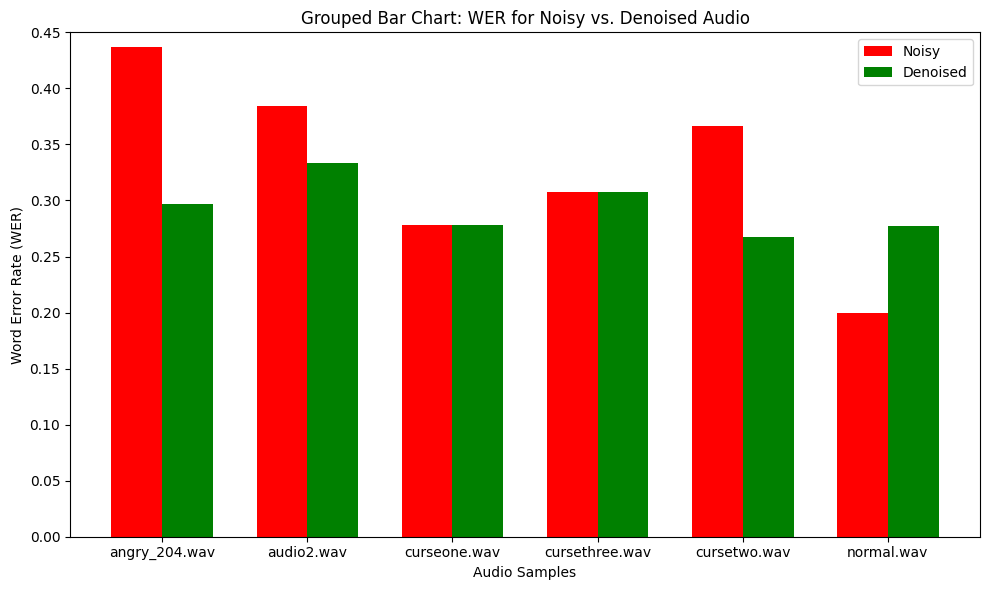

In [8]:
x_labels = audio_name
x = np.arange(len(x_labels))
width = 0.35 

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, noisy_wers, width, label='Noisy', color='red')
plt.bar(x + width/2, denoised_wers, width, label='Denoised', color='green')


plt.ylabel('Word Error Rate (WER)')
plt.xlabel('Audio Samples')
plt.title('Grouped Bar Chart: WER for Noisy vs. Denoised Audio')
plt.xticks(x, x_labels)
plt.ylim(0, 0.45)
plt.legend()
plt.tight_layout()

plt.show()

# Results:
The average WER score is about **0.29**, which is a great improvement from the earlier **0.35** (from the presentation). These improvements were made after I realised that lower amplitide audio was getting muffled during de-noising and had to change the **prop_decrease** and **top_db** parameters to better reduce the noice. RMS was calculated to get the average loudness in the audio.

While denoising the audio certainly is helping, the WER scores can be further improved by fine-tuning the parameters for the reduce_noise functions.

Noticibaly, a lot of missed transcription is due to punctuation mismatch. These errors were not a big problem, as toxic-bert is able to detect the toxicity in the audio pretty accurately without proper punctuations. Toxic bert has accuracy of about 0.98 (ref: https://dataloop.ai/library/model/unitary_toxic-bert/). 

While classification poses no issues, WER must be improved for better cuss-word-detection. If such words go un-noticed, they will not be censored and may be heard by the naive audience.